In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='P003':
    print('Not in /P003 folder, changing directory to P003')
    lib_path = os.path.expanduser(os.path.relpath('~/images/codesDIR/datathon2020/P003'))
    os.chdir(lib_path)

In [3]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch import optim

from torch.nn import MSELoss, L1Loss
# Neural network implementations: fcNet, diffNet
from src.nnets import get_model, train_model
from src import nnets
from src.utils import mse, lagged_xcorr

import matplotlib
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,5)
# matplotlib.rcParams['font.size']= 22 # use for presentation


if torch.cuda.is_available():
    device = torch.device('cuda')
#     device = torch.device('cuda:3')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cuda


In [4]:
import pandas as pd
from trader import trader_simulation

In [5]:
with open('persistence_T18.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
lead_time = persistence['lead_time']
print('Persistence:',persistence)

Persistence: {'lead_time': 18, 'Persistence_Euclidean': 0.10196654967828511, 'Persistence_MSE': 0.20393309935657022, 'Persistence_MAE': 0.3105751548586914}


In [6]:
# Path for Datasets:
# all preprocessed data will be saved in `data_path`
data_path = os.path.relpath('../../../dataDIR/'+'preprocessed_linearinterp_avgmodels')
print(f'> Preprocessed data is from `{data_path}`\n')
# !ls $data_path

> Preprocessed data is from `../../../dataDIR/preprocessed_linearinterp_avgmodels`



In [7]:
pd.to_datetime('2020-07-27 15:00:00')-pd.Timedelta(hours=17)

Timestamp('2020-07-26 22:00:00')

In [289]:
pd.to_datetime('2020-07-26 22:00:00')+pd.Timedelta(hours=8)

Timestamp('2020-07-27 06:00:00')

In [287]:
pd.to_datetime('2020-07-27 17:00:00')-pd.Timedelta(hours=17)

Timestamp('2020-07-27 00:00:00')

In [288]:
pd.to_datetime('2020-07-27 00:00:00')+pd.Timedelta(hours=8)

Timestamp('2020-07-27 08:00:00')

## Dataset Notes

- Clock: for `YXdifwind40_speedclock` 
```python
# datasets:
train_fname = os.path.join(data_path,'train_preprocessed_YXdifwind40_speedclock.npy')
test_fname = os.path.join(data_path,'test_preprocessed_YXdifwind40_speedclock.npy')
```
```python
# best diffnet:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1
```

- diff(Y,X) W=40, X(T+18),
```python
# Training data
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
```

- diff(Y, wind features) W=20,40,80, Wind features(T+18)
```python
window_size = 40
# Training data
train_fname = os.path.join(data_path,f'train_preprocessed_Ydiffwind_feature_w{window_size}.npy')
test_fname = os.path.join(data_path,f'test_preprocessed_Ydiffwind_feature_w{window_size}.npy')
```

## Train Old Model

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32

Training x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])

epoch 0> train_loss: 0.20427870750427246, test_loss: 0.20267702639102936
epoch 25> train_loss: 0.07649775594472885, test_loss: 0.08589493483304977
epoch 50> train_loss: 0.05365438014268875, test_loss: 0.06817850470542908
epoch 75> train_loss: 0.04424541816115379, test_loss: 0.06180084869265556
epoch 100> train_loss: 0.03909020125865936, test_loss: 0.05788882449269295
epoch 125> train_loss: 0.03686654195189476, test_loss: 0.05730264261364937
epoch 150> train_loss: 0.03454309329390526, test_loss: 0.056432224810123444
epoch 175> train_loss: 0.03228596970438957, test_loss: 0.055801331996917725
epoch 200> train_loss: 0.029902558773756027, test_loss: 0.05510711669921875
epoch 225> train_loss: 0.02859828993678093, t

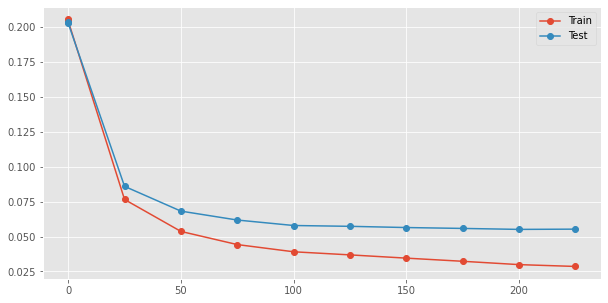

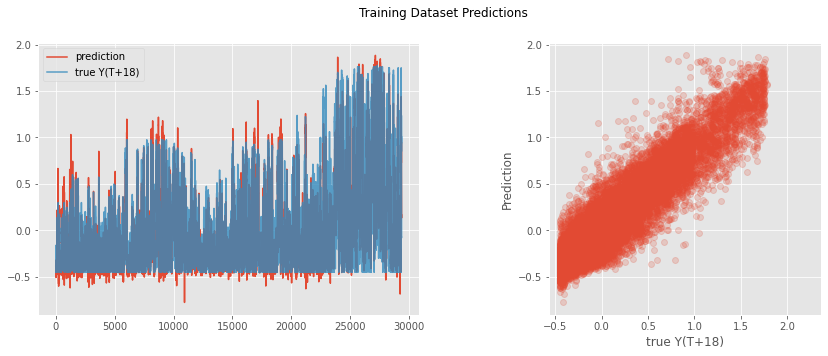

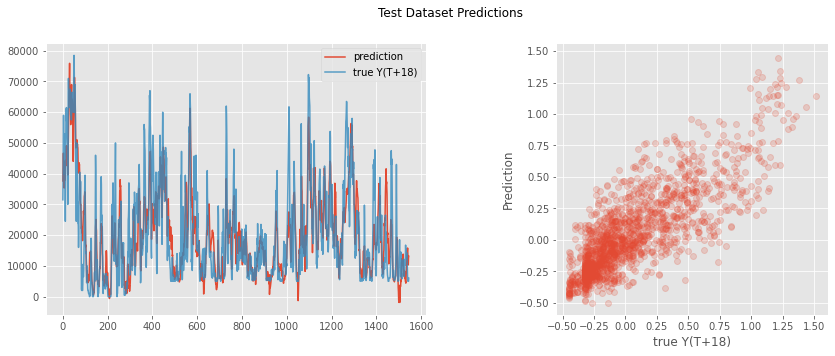

MSE loss (np): 0.05525653


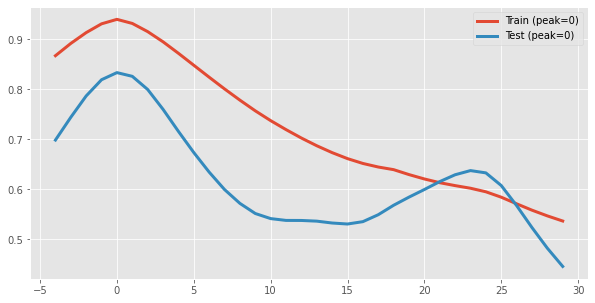

Train lag peak:0
Test lag peak:0
Net profit(euro cents):159358703.9453125
Profit: 159.4 millions


In [7]:
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')


# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 250    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100



net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test*40000+18000,label='prediction')
axs[0].plot(target_test*40000+18000,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')


target_kwh = target_test.ravel()*40000+18000
y_pred_kwh = np.maximum(0,pred_test.ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

### Modified Loss Function 

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32

Training x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])

epoch 0> train_loss: 0.14630615711212158, test_loss: 0.1534443348646164
epoch 20> train_loss: 0.09673520922660828, test_loss: 0.09917711466550827
epoch 40> train_loss: 0.0800132155418396, test_loss: 0.0905856117606163
epoch 60> train_loss: 0.06743911653757095, test_loss: 0.07979096472263336
epoch 80> train_loss: 0.061954397708177567, test_loss: 0.07582434266805649
epoch 100> train_loss: 0.05853903293609619, test_loss: 0.07500755041837692
epoch 120> train_loss: 0.056734878569841385, test_loss: 0.07436926662921906
epoch 140> train_loss: 0.055153604596853256, test_loss: 0.07370821386575699
epoch 160> train_loss: 0.053463734686374664, test_loss: 0.07317714393138885
epoch 180> train_loss: 0.05230211094021797, test

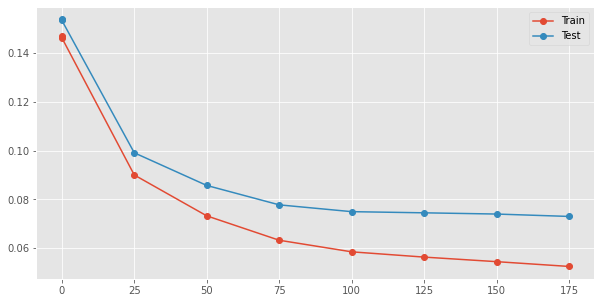

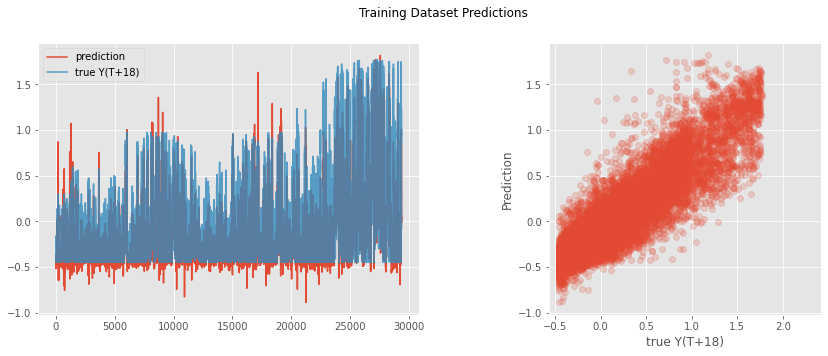

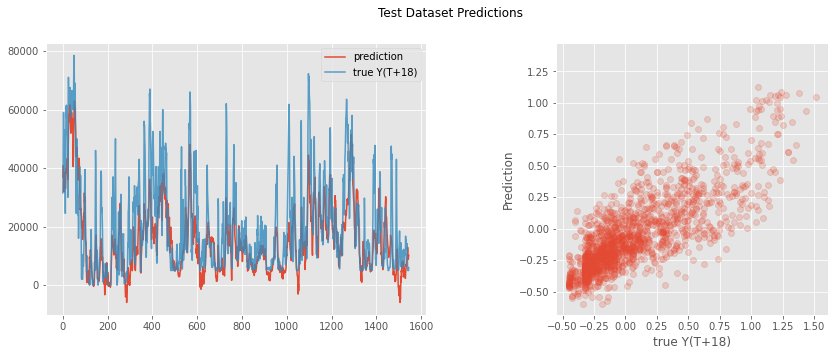

MSE loss (np): 0.073499486


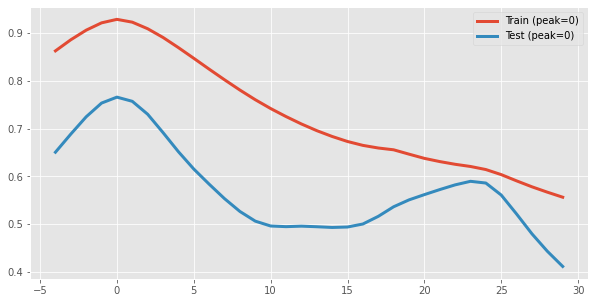

Train lag peak:0
Test lag peak:0
Net profit(euro cents):174894204.75585938
Profit: 174.9 millions


In [178]:
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')


# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.3,.2,.2,.2,.1]
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 200    # total number of training epochs == training iterations for the batch
# loss_func = MSELoss(reduction='mean')
# v1:
# loss_func = lambda yp,yt: torch.mean(torch.clamp(yt-yp,min=0)/3+ 2*torch.clamp(yp-yt,min=0)/3)
# v2:
loss_func = lambda yp,yt: torch.mean(torch.clamp(yt-yp,min=0)/3.25+ 2.25*torch.clamp(yp-yt,min=0)/3.25)

test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100



net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test*40000+18000,label='prediction')
axs[0].plot(target_test*40000+18000,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')


target_kwh = target_test.ravel()*40000+18000
y_pred_kwh = np.maximum(0,pred_test.ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

In [114]:
# import ,os
# location of networks
# model_dir = os.path.relpath('./best_models')
# get all models that match the pattern:
# model_filenames = glob.glob(os.path.join(model_dir,'20Jul2020*'))
# model_filenames = ['best_models/24Jul2020_0150_ver1.pkl']

In [154]:
import pickle, os, glob
# location of networks
file_name = os.path.join(os.path.relpath('./best_models'),'27Jul2020_1023_v5.pkl')
# Save
with open(file_name, 'wb') as f:
    with torch.no_grad():
        net.eval()
        net.cpu()
        pickle.dump(net, f)
        net.to(device)

/mnt/mbi/home/murat/.local/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## New Model

In [144]:
from src.nnets import dense , diffmlp
# class dense(nn.Module):
#     def __init__(self,in_dim,out_dim, p=0, Fn=nn.ReLU, Fn_kwargs={}):
#         super(dense,self).__init__()
#         self.linear = nn.Linear(in_dim, out_dim)
#         self.activation = Fn(**Fn_kwargs)
#         if p:
#             self.dropout=nn.Dropout(p= p)
#         self.p = p
#     def forward(self, x):
#         '''x: input vector'''
#         x=self.linear(x)
#         x= self.activation(x)
#         if self.p:
#             x=self.dropout(x)
#         return x

# class diffmlp(nn.Module):
#     def __init__(self,in_dim,out_dim=1,layer_dims=[], dropout_p=[], Fn=nn.ReLU, Fn_kwargs={}):
#         super(diffmlp,self).__init__()
#         assert len(layer_dims)>0
#         assert len(dropout_p)==0 or len(dropout_p)==1 or len(dropout_p)==len(layer_dims)
#         if len(dropout_p)==1:
#             dropout_p = [dropout_p[0] for k in range(len(layer_dims)) ]
        
#         layers = [('dense1',dense(in_dim, layer_dims[0],p=0 if len(dropout_p)==0 else dropout_p[0],
#                                          Fn=Fn, Fn_kwargs=Fn_kwargs))
#                         ]# input->layer1
        
#         for k in range(len(layer_dims)-1):
#             layers.append(('dense'+str(k+2),dense(layer_dims[k],layer_dims[k+1],
#                                                   p=0 if len(dropout_p)==0 else dropout_p[k+1],
#                                                   Fn=Fn, Fn_kwargs=Fn_kwargs) ) )
#         self.layers = nn.ModuleDict(layers)
#         self.output_layer  = nn.Linear(layer_dims[-1], out_dim)
#     def forward(self, x, y0):
#         '''x: input vector'''
#         for l in self.layers:
#             x = self.layers[l](x)
#         x_out = self.output_layer(x)+y0
#         return x_out

def posenc(x,L_embed=4):
    embeds = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            embeds.append(fn(2.**(-i) * x))
    return torch.cat(embeds, 1)
    
class diffmlp_enc(nn.Module):
    def __init__(self,in_dim,out_dim=1,L_embed=4,layer_dims=[], dropout_p=[], Fn=nn.ReLU, Fn_kwargs={}):
        super(diffmlp_enc,self).__init__()
        assert len(layer_dims)>0
        assert len(dropout_p)==0 or len(dropout_p)==1 or len(dropout_p)==len(layer_dims)
        if len(dropout_p)==1:
            dropout_p = [dropout_p[0] for k in range(len(layer_dims)) ]
        in_dim = in_dim*(L_embed*2+1)
        
        layers = [('dense1',dense(in_dim, layer_dims[0],p=0 if len(dropout_p)==0 else dropout_p[0],
                                         Fn=Fn, Fn_kwargs=Fn_kwargs))
                        ]# input->layer1
        
        for k in range(len(layer_dims)-1):
            layers.append(('dense'+str(k+2),dense(layer_dims[k],layer_dims[k+1],
                                                  p=0 if len(dropout_p)==0 else dropout_p[k+1],
                                                  Fn=Fn, Fn_kwargs=Fn_kwargs) ) )
        self.layers = nn.ModuleDict(layers)
        self.output_layer  = nn.Linear(layer_dims[-1], out_dim)
        self.L_embed = L_embed
    def forward(self, x, y0):
        '''x: input vector'''
        x = posenc(x,L_embed=self.L_embed)
        for l in self.layers:
            x = self.layers[l](x)
        x_out = self.output_layer(x)+y0
        return x_out


In [196]:
# z = torch.arange(0,1,.01).view(1,-1)
# z_enc = posenc(z)
# fn_name = ['1']
# for k in range(4):
#     fn_name.append('sin(2^'+str(k)+'*x)')
#     fn_name.append('cos(2^'+str(k)+'*x)')
# for k in range(9):
#     plt.plot(z.view(-1,),z_enc[:,z.shape[1]*k:z.shape[1]*(k+1)].view(-1,),label=fn_name[k])
# plt.legend();

In [145]:
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

# train_fname = os.path.join(data_path,'train_preprocessed_YXdifwind40_speedclock.npy')
# test_fname = os.path.join(data_path,'test_preprocessed_YXdifwind40_speedclock.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32



In [146]:
x = X_train[:,2:] # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1) #Y(T+0)
y = X_train[:,:1] # Y(T+lead_time)
print(f'(training) x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')
x, Y0, y = x.to(device), Y0.to(device), y.to(device)

x_test = X_test[:,2:] # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1) #Y(T+0)
y_test = X_test[:,:1] # Y(T+lead_time)
print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')

train_ds = TensorDataset(x,Y0,y)
test_ds = TensorDataset(x_test,Y0_test,y_test)

(training) x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])



In [193]:
input_dim = x.shape[1]
layer_dims = [128 for k in range(5)]
dropout_p = [ 0.2]
out_dim = 1

# Training parameters
batch_size = 512#x.shape[0] # number of training runs per configuration
learning_rate = 0.003 # default for Adam: 0.001
epochs = 10000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
# loss_func = L1Loss(reduction='mean')
test_intervl =10 # collect loss every "test_intervl" iter-n

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

# model = diffmlp(input_dim,out_dim=out_dim,layer_dims=layer_dims,dropout_p=dropout_p).to(device)
model = diffmlp_enc(input_dim,out_dim=out_dim,L_embed=3,layer_dims=layer_dims,dropout_p=dropout_p).to(device)

opt = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
# opt = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=10**(-6))

# scheduler = None 
scheduler=torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler

train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds))

In [194]:
train_epochs=[]
train_loss=[]
test_loss=[]
model.to(device)
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    num_total = 0
    for x_batch,y0_batch,y_batch in train_dl:
        #x_batch, y0_batch, y_batch = x_batch.to(device), y0_batch.to(device), y_batch.to(device)
        
        pred = model(x_batch,y0_batch)
        loss = loss_func(pred, y_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        epoch_loss+=len(x)*loss.item()
        num_total+=len(x)
    
    model.eval() # for validation
    with torch.no_grad():
        # save for plotting
        if (epoch%test_intervl==0) or (epoch==epochs):
            train_epochs.append(epoch)
            train_loss.append(epoch_loss/num_total)
            nums,losses = zip(*[[len(x),
                                 loss_func(model(x.to(device),y0.to(device)), y.to(device)).item()
                                ] for x,y0,y in test_dl] )
            test_loss.append(np.sum(np.multiply(nums,losses))/np.sum(nums))
            
            print('epoch {}> train_loss: {}, test_loss: {}'.format(
                train_epochs[-1],train_loss[-1],test_loss[-1]))
    if scheduler!=None:
        # change learning rate
        scheduler.step()

epoch 0> train_loss: 0.204842918648802, test_loss: 0.20236167311668396
epoch 10> train_loss: 0.20344989258667517, test_loss: 0.2012401968240738
epoch 20> train_loss: 0.15764431629715295, test_loss: 0.14883503317832947
epoch 30> train_loss: 0.0961063468250735, test_loss: 0.10329144448041916
epoch 40> train_loss: 0.08513533182699105, test_loss: 0.09674479812383652
epoch 50> train_loss: 0.0786087965143138, test_loss: 0.08276363462209702
epoch 60> train_loss: 0.0758345655069269, test_loss: 0.07411147654056549
epoch 70> train_loss: 0.07369919320375755, test_loss: 0.10133002698421478
epoch 80> train_loss: 0.06806927906541989, test_loss: 0.07591696828603745
epoch 90> train_loss: 0.067836401277575, test_loss: 0.08299851417541504
epoch 100> train_loss: 0.06476442567233381, test_loss: 0.07214954495429993
epoch 110> train_loss: 0.06518158502876759, test_loss: 0.06324205547571182
epoch 120> train_loss: 0.06236021259221537, test_loss: 0.06796465814113617
epoch 130> train_loss: 0.06118160280688056, 

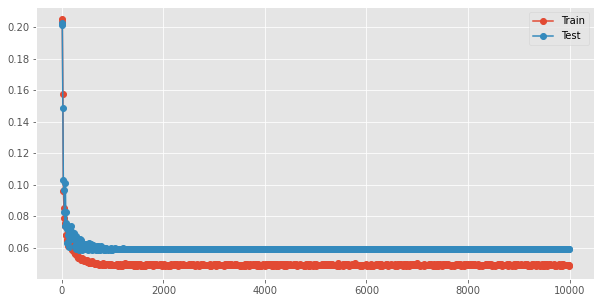

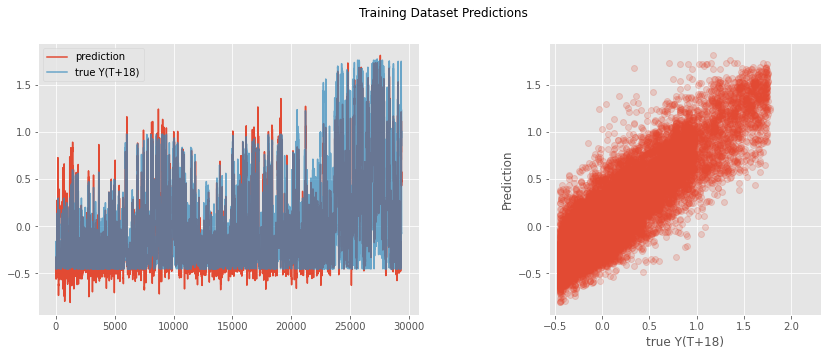

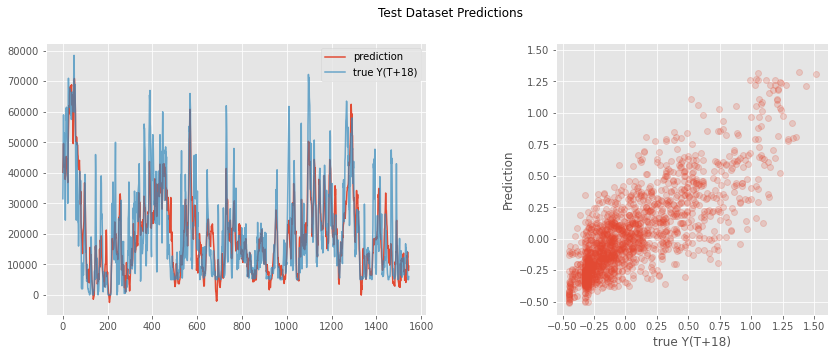

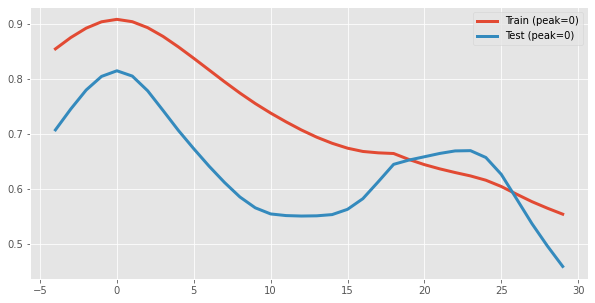

Train lag peak:0
Test lag peak:0
MSE loss (np): 0.059240073
Net profit(euro cents):157176616.73828125
Profit: 157.2 millions


In [195]:
plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
model.eval()
pred = model(x.to(device), Y0.to(device) ).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = model(x_test.to(device), Y0_test.to(device) ).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.7)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test*40000+18000,label='prediction')
axs[0].plot(target_test*40000+18000,label=f'true Y(T+{lead_time})',alpha=.7)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

target_kwh = target_test.ravel()*40000+18000
y_pred_kwh = np.maximum(0,pred_test.ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

In [60]:
# def train_model_dl(model,train_dl,test_dl,opt, loss_func,
#                 epochs=100, test_intervl=25, print_times=10, scheduler=None):
#     '''
#     Arg-s:
#     - optim : optimizer/ solver
#     - test_intervl: collect loss every "test_intervl" iter-n
#     - print_times : number of times to print loss to the terminal
#     - epochs : total number of training epochs == training iterations for the batch
#     '''
#     train_epochs=[]
#     train_loss=[]
#     test_loss=[]
#     #     test_epochs=[]

#     # Training iterations:
#     for epoch in range(epochs):
#         model.train()
#         epoch_loss =0
#         num_total = 0
#         for x,y0, y in train_dl:
#             # x= x.to(device)
#             # y0= y0.to(device)
#             # y= y.to(device)
#             pred = model(x,y0)
#             loss = loss_func(pred, y)

#             loss.backward()
#             opt.step()
#             opt.zero_grad()

#             epoch_loss+=len(x)*loss.item()
#             num_total+=len(x)
#         train_epochs.append(epoch)
#         train_loss.append(epoch_loss/num_total)

#         model.eval() # for validation
#         with torch.no_grad():
#             # save for plotting
#             nums,losses = zip(*[[len(x), loss_func(
#                 model(x.to(device),y0.to(device)), y.to(device)).item() ]
#                                 for x,y0,y in test_dl])
#             nums,losses = zip(*[ 
#                 [len(x), loss_func(model(x,y0, y)).item() ] for x,y0,y in test_dl ]
#                              )
#             test_loss.append(np.sum(np.multiply(nums,losses))/np.sum(nums))

#             # print to terminal
#         if epoch%(epochs//print_times)==0:
#             print('epoch {}> train_loss: {}, test_loss: {}'.format(
#                 epoch,train_loss[-1],test_loss[-1]))
#             #print(scheduler.get_lr()) # to verify lr
#         if scheduler!=None:
#             # change learning rate
#             scheduler.step()
#     return train_epochs, train_loss, test_loss


## Saving models

In [114]:
import glob,os
# location of networks
model_dir = os.path.relpath('./test_models')
# get all models that match the pattern:
# model_filenames = glob.glob(os.path.join(model_dir,'20Jul2020*'))
# model_filenames = ['best_models/24Jul2020_0150_ver1.pkl']

In [33]:
# import pickle, os
# # location of networks
# file_name = os.path.join(os.path.relpath('./test_models'),'26Jul2020_0100_v3.pkl')
# # Save
# with open(file_name, 'wb') as f:
#     with torch.no_grad():
#         model.eval()
#         model.cpu()
#         pickle.dump(model, f)
#         model.to(device)

In [162]:
import pickle,glob
from src.nnets import dense, diffmlp

model_filenames = glob.glob(os.path.join(os.path.relpath('./best_models'),'27Jul2020_1023_*'))
# model_filenames.extend(glob.glob(os.path.join(os.path.relpath('./best_models'),'25Jul2020_*'))[:2])

modellist = []
for fname in model_filenames:
    with open(fname, 'rb') as f:
        print(f'Loading {fname}')
        modellist.append(pickle.load(f))

for net in modellist:
    net.to(device)

def predictT18(x,y_0,nets=modellist):
    results = []
    y_0 = y_0.to(device)
    x = x.to(device)
    with torch.no_grad():
        for net in modellist:
            net.eval()
            #print(net(x,y_0).detach().cpu().numpy().shape)
            results.append(net(x,y_0).detach().cpu().numpy())
    
    return results

Loading best_models/27Jul2020_1023_v4.pkl
Loading best_models/27Jul2020_1023_v1.pkl
Loading best_models/27Jul2020_1023_v5.pkl
Loading best_models/27Jul2020_1023_v2.pkl
Loading best_models/27Jul2020_1023_v3.pkl


In [163]:
# net.cpu()
# import pickle
# file_name = './best_models/_ver5.pkl'
# # Save
# with open(file_name, 'wb') as f:
#   pickle.dump(net, f)

In [164]:
# x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
# Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
# y_test = X_test[:,:1].to(device) # Y(T+lead_time)

In [165]:
ypred_5 = predictT18(x_test,Y0_test)
ypred_5 = np.concatenate(ypred_5,axis=1)

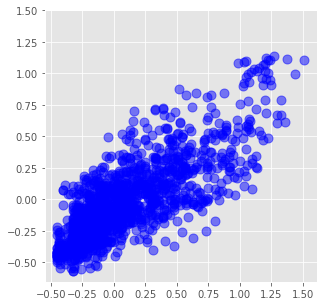

In [166]:
plt.plot(y_test.detach().cpu().numpy(),ypred_5.mean(axis=1,keepdims=True),'bo',ms=9,alpha=.5)
plt.axis('square');

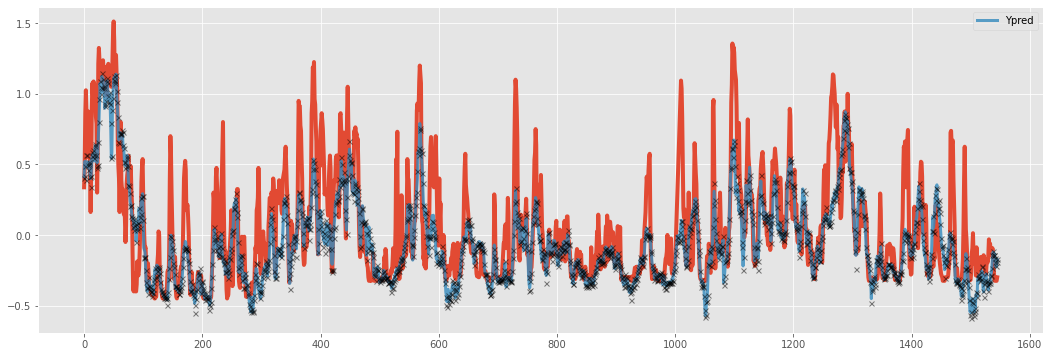

In [167]:
plt.figure(figsize=[18,6])
plt.plot(y_test.detach().cpu().numpy(),'-',lw=4)
plt.plot(ypred_5.mean(axis=1,keepdims=True),lw=3,alpha=.8,label='Ypred')
plt.plot(ypred_5[:,0],'kx',ms=5,alpha=.5)
plt.legend();


In [168]:
target_kwh = y_test.detach().cpu().numpy().ravel()*40000+18000
y_pred_kwh = np.maximum(0,ypred_5.mean(axis=1,keepdims=True).ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

Net profit(euro cents):178013535.703125
Profit: 178.0 millions


In [70]:
# target_kwh = y_test.detach().cpu().numpy().ravel()*40000+18000
# y_pred_kwh = np.maximum(0,ypred_5_25.mean(axis=1,keepdims=True).ravel()*40000+18000)
# profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
# print(f'Profit: {profits/10**6:.1f} millions')

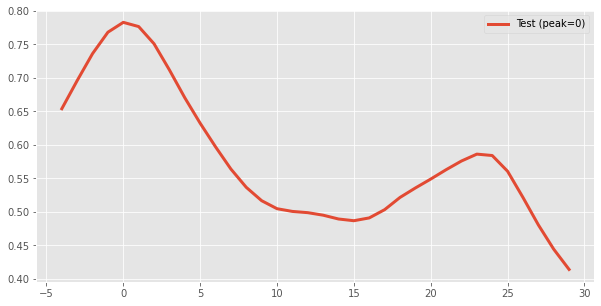

Test lag peak:0


In [169]:
# Lagged (Cross-) Correlation:
test_lags, test_xcorr   = lagged_xcorr( ypred_5.mean(axis=1,keepdims=True).ravel(), y_test.detach().cpu().numpy().ravel())
lag_min = -5
lag_max = 30

test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
# train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

# plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
# print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')